In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
from math import exp
import random
import re
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from functions import *

# Topt: dataset split

In [2]:
topt_data = pd.read_csv('../data/Topt/sequence_ogt_topt.csv') # obtained from TOMER (https://doi.org/10.1021/acs.jcim.0c00489)
topt_data = topt_data[['uniprot_id','topt','sequence']]

In [3]:
def split_table( table, ratio ):
    idx=list(table.index)
    np.random.shuffle(idx)
    num_split = int( len(idx) * ratio)
    idx_test, idx_train = idx[:num_split], idx[num_split:]
    train_table = (table.iloc[idx_train]).reset_index().drop(['index'],axis=1)
    test_table = (table.iloc[idx_test]).reset_index().drop(['index'],axis=1)
    return train_table,test_table

In [7]:
train, test = split_table(topt_data, ratio=0.1)

In [8]:
# train.to_csv('../data/train.csv',index=None)
# test.to_csv('../data/test.csv',index=None)

In [10]:
# fig, axs = plt.subplots(1,2, figsize=(10,4))
# axs[0].hist(train['topt'])
# axs[1].hist(test['topt'])

In [11]:
train = pd.read_csv('../data/Topt/train.csv'); test=pd.read_csv('../data/Topt/test.csv');

In [12]:
# Oversampling for T >= 80 C
# train_os = train.copy()
# high_ot = (train[train['topt']>=80]).reset_index().drop(['index'],axis=1)
# over_high = []
# for i in range( len(high_ot.index) ):
#     rand_idx = np.random.randint( len( high_ot.index ) - 1,size=1)[0]
#     temp_data = dict( high_ot.iloc[rand_idx] )
#     over_high.append( temp_data )
# over_pd = pd.DataFrame(over_high)
# train_os = ( pd.concat([ train_os, over_pd]) ).reset_index().drop(['index'],axis=1)
# train_os.to_csv('../data/train_os.csv',index=None)

In [13]:
train_os = pd.read_csv('../data/Topt/train_os.csv')

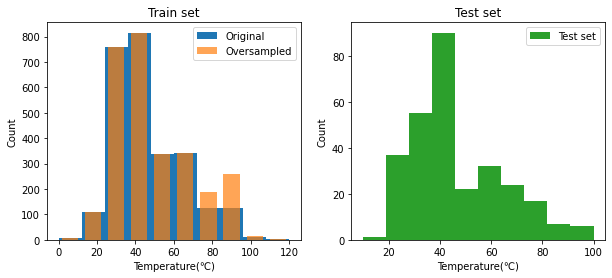

In [21]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].hist(train['topt'],alpha=1,label='Original');
axs[0].hist(train_os['topt'],alpha=0.7, histtype='barstacked',rwidth=0.7, label='Oversampled')
axs[0].set_title('Train set')
axs[1].hist(test['topt'], bins=10, color='tab:green', label='Test set');
axs[1].set_title('Test set')
for ax in axs:
    ax.set_xlabel('Temperature(\u2103)')
    ax.set_ylabel('Count')
    ax.legend()

In [22]:
print(len(train_os.index))
print(len(test.index))

2829
291


## prep input for preoptem

In [6]:
test=pd.read_csv('../data/Topt/test.csv');
test.head()

,uniprot_id,topt,sequence
0,A5DNB9,30.0,MADNEPAMATKQHNAELLPPTRTTSEPPLYKRLGNMVIPPLQSSFS...
1,O66680,65.0,MMKEFNPREIEKKWQKRWEEAGVFKAQEGKPNKFYVLEMFPYPSGR...
2,O66932,100.0,MEEEKVKEGLWELAYNLWWTWNPPAKELFRSIDPLLWKETKENPIE...
3,Q54BM7,37.0,MITNSKMENKILDEFDEEELNKLKINSNNKESTTTTTSTTTTTTTT...
4,D3YBH2,36.5,MKMVPDGGEPTCEELDALRERLSSPELDQRHLFNGWPASAEEYTEE...


In [7]:
records = []
for i in range(len(test.index)):
    records.append( SeqRecord( Seq(list(test['sequence'])[i]), 
                              id =list(test['uniprot_id'])[i], description='' ) )
SeqIO.write(records,'../data/test_preoptem.fasta',"fasta")

291

# pHopt

In [29]:
train_records = SeqIO.parse( '../data/pHopt/phopt_training.fasta' , "fasta")
val_records = SeqIO.parse( '../data/pHopt/phopt_validation.fasta' , "fasta")
test_records = SeqIO.parse( '../data/pHopt/phopt_testing.fasta' , "fasta")
def records_to_table(records):
    data = []
    for record in records:
        temp = {'uniprot_id':str(record.id).strip(),'sequence':str(record.seq)}
        temp['pHopt'] = float( record.description.split('|')[3] )
        temp['EC'] = record.description.split('|')[2].strip()
        temp['Organism'] = record.description.split('|')[1].strip()
        data.append(temp)
    table = pd.DataFrame(data)
    return table

In [30]:
train_set = records_to_table(train_records)
val_set = records_to_table(val_records)
test_set = records_to_table(test_records)
train_data = pd.concat([train_set, val_set])

In [36]:
# train_data.to_csv('../data/pHopt/train_pH.csv',index=None)
# test_set.to_csv('../data/pHopt/test_pH.csv',index=None)

# Default hyperparameters

In [3]:
# default_dict = { 'dim':320,'window':5,'dropout':0.1,'n_head':4,'n_RD':3 }
# dump_pickle( default_dict, '../data/performances/default.pkl')

In [37]:
# win_sizes = [3,5,7]; nRDs = [2,3,4,5];
# for win_size in win_sizes:
#     for n_RD in nRDs:
#         temp_dict = { 'window': win_size,'dropout':0.1,'n_head':4,'n_RD': n_RD }
#         temp_name = 'w'+str(win_size)+'nRD'+str(n_RD)
#         dump_pickle( temp_dict, '../data/hyparams/'+temp_name+'.pkl')